In [62]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import time

In [91]:
df = pd.read_csv('data/train_preprocessed.csv')
df.head()

,SK_ID_CURR,W_DEFAULT,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,AMT_LESS_MAX,DAYS_LATE_AVG,DAYS_LATE_MAX,SK_DPD_DEF,LESS_GRANTED,REJECTED_APPLICATIONS,AMT_CREDIT_SUM_TOTAL,AMT_CREDIT_SUM_DEBT_TOTAL,AMT_CREDIT_SUM_LIMIT_TOTAL,AMT_CREDIT_SUM_OVERDUE_TOTAL
0,100002,1.0,0,1,0,202500.0,Working,Secondary / secondary special,Single / not married,House / apartment,...,0.000,20.421053,31.0,0.0,0.0,0.0,865055.565,245781.0,31988.565,0.0
1,100003,0.0,0,0,0,270000.0,State servant,Higher education,Married,House / apartment,...,0.000,7.160000,14.0,0.0,1.0,0.0,1017400.500,0.0,810000.000,0.0
2,100004,0.0,1,1,0,67500.0,Working,Secondary / secondary special,Single / not married,House / apartment,...,0.000,7.666667,11.0,0.0,1.0,0.0,189037.800,0.0,0.000,0.0
3,100006,0.0,0,1,0,135000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,...,0.000,19.375000,77.0,0.0,2.0,1.0,NaN,NaN,NaN,NaN
4,100007,0.0,0,1,0,121500.0,Working,Secondary / secondary special,Single / not married,House / apartment,...,22655.655,4.590909,31.0,0.0,2.0,0.0,146250.000,0.0,0.000,0.0


In [99]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

categoricals = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
cols_to_scale = [
    'Avg_Monthly_Balance','Months_Fully_Paid', 
    'Months_Minimum_Paid', 'Months_Minimum_Paid', 
    'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'OWN_CAR_AGE',
    'Age_Years','Employed_Months', 'AMT_LESS_TOTAL',
    'AMT_LESS_MAX', 'DAYS_LATE_MAX', 'SK_DPD_DEF',
    'AMT_CREDIT_SUM_TOTAL', 'AMT_CREDIT_SUM_DEBT_TOTAL',
    'AMT_CREDIT_SUM_LIMIT_TOTAL', 'AMT_CREDIT_SUM_OVERDUE_TOTAL',
    'Tenure_Months', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
]
others = df.columns.difference(categoricals + cols_to_scale)

preproc = ColumnTransformer([
    ('cat', OneHotEncoder(), categoricals),
    ('scaled', MinMaxScaler(), cols_to_scale),
], remainder='passthrough')

In [102]:
X = df.drop(columns='W_DEFAULT')
y = df['W_DEFAULT']

X = preproc.fit_transform(X)

In [103]:
column_names = preproc.get_feature_names_out()

In [ ]:
X[np.isnan(X)] = 0  #naively fill NA with 0

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

from imblearn.over_sampling import ADASYN
adasyn = ADASYN(sampling_strategy=0.3, random_state=1)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

In [59]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score, matthews_corrcoef
from sklearn.metrics import precision_recall_curve, auc, make_scorer

def auc_prc(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

auc_prc_score = make_scorer(auc_prc, needs_proba=True)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [63]:
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

param_space = {
    'n_estimators': Integer(50, 250),
    'max_depth': Integer(3, 10),
    'eta': Real(0.01, 0.5),
    'gamma': Real(0, 1),
    'min_child_weight': Real(1, 10),
    # 'scale_pos_weight': Real(1, 15),
    'max_delta_step': Real(1, 10),
    'colsample_bytree': Real(0.5, 1),
    'subsample': Real(0.5, 1),
    'lambda': Real(0.01, 10),
    'alpha': Real(0.01, 10),
}

model = XGBClassifier(objective='binary:logistic', eval_metric='auc')

opt = BayesSearchCV(
    model,
    param_space,
    # random_state=0,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'
)
# Record start time
start_time = time.time()
print(f"Model training started at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time))}")


opt.fit(X_train, y_train)

# Record end time
end_time = time.time()

print(f"Model training ended at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time))}")
print(f"Total Training Time: {end_time - start_time:.2f} seconds")

best_model = opt.best_estimator_

# Print the best parameters
print("Best Hyperparameters:", opt.best_params_)

Model training started at: 2024-11-27 22:27:58
Model training ended at: 2024-11-27 22:38:57
Total Training Time: 658.61 seconds
Best Hyperparameters: OrderedDict({'alpha': 10.0, 'colsample_bytree': 0.5, 'eta': 0.06378779149966156, 'gamma': 0.38372879913599683, 'lambda': 10.0, 'max_delta_step': 10.0, 'max_depth': 9, 'min_child_weight': 10.0, 'n_estimators': 250, 'subsample': 0.9386880085037652})


In [64]:
best_model = XGBClassifier(**opt.best_params_)
best_model.fit(X_train, y_train)

results = {}

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

results['XGBoost'] = {
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba[:,1]),
    'PRC AUC': auc_prc(y_test, y_pred),
    'MCC': matthews_corrcoef(y_test, y_pred)
}

pd.DataFrame.from_dict(results, orient='index')

,Precision,Recall,F1,ROC AUC,PRC AUC,MCC
XGBoost,0.53125,0.027336,0.051996,0.765581,0.318634,0.106781


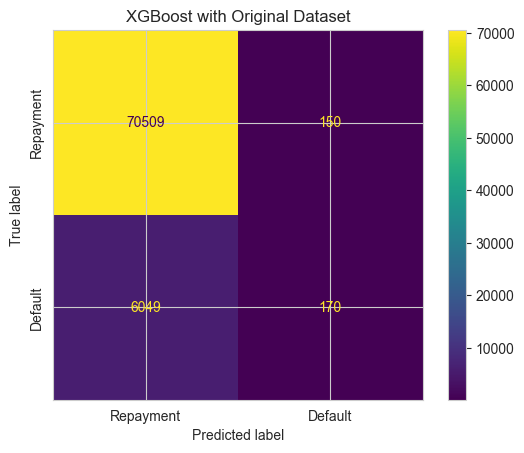

In [65]:
cm = confusion_matrix(y_test, y_pred)

from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Repayment', 'Default'])
cm_display.plot()
plt.yticks(rotation=90, va='center')
plt.gca().set_title('XGBoost with Original Dataset');

In [68]:
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

param_space = {
    'n_estimators': Integer(50, 250),
    'max_depth': Integer(3, 10),
    'eta': Real(0.01, 0.5),
    'gamma': Real(0, 1),
    'min_child_weight': Real(1, 10),
    # 'scale_pos_weight': Real(1, 15),
    'max_delta_step': Real(1, 10),
    'colsample_bytree': Real(0.5, 1),
    'subsample': Real(0.5, 1),
    'lambda': Real(0.1, 10),
    'alpha': Real(0.1, 10),
}

model = XGBClassifier(objective='binary:logistic', eval_metric='auc')

opt_adasyn = BayesSearchCV(
    model,
    param_space,
    # random_state=0,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'
)

# Record start time
start_time = time.time()
print(f"Model training started at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time))}")
opt_adasyn.fit(X_adasyn, y_adasyn)

# Record end time
end_time = time.time()

print(f"Model training ended at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time))}")
print(f"Total Training Time: {end_time - start_time:.2f} seconds")

best_model = opt_adasyn.best_estimator_

# Print the best parameters
print("Best Hyperparameters:", opt_adasyn.best_params_)

Model training started at: 2024-11-27 22:42:33
Model training ended at: 2024-11-27 23:01:35
Total Training Time: 1142.16 seconds
Best Hyperparameters: OrderedDict({'alpha': 10.0, 'colsample_bytree': 0.7824933997497413, 'eta': 0.060297384701445175, 'gamma': 1.0, 'lambda': 10.0, 'max_delta_step': 10.0, 'max_depth': 10, 'min_child_weight': 1.0, 'n_estimators': 193, 'subsample': 1.0})


,Precision,Recall,F1,ROC AUC,PRC AUC,MCC
XGBoost + ADASYN,0.514184,0.023316,0.044609,0.765136,0.308254,0.096418


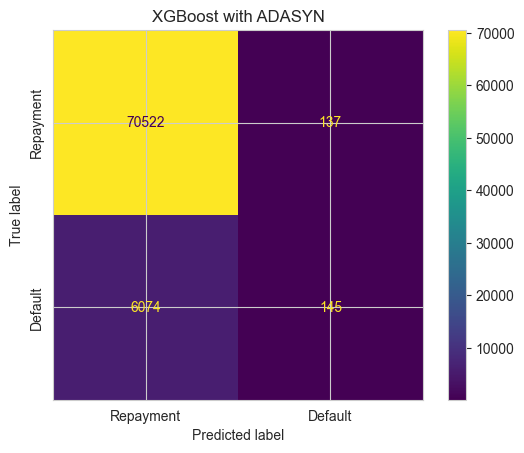

In [69]:
best_model_adasyn = XGBClassifier(**opt_adasyn.best_params_)
best_model_adasyn.fit(X_adasyn, y_adasyn)

results = {}

y_pred = best_model_adasyn.predict(X_test)
y_proba = best_model_adasyn.predict_proba(X_test)

results['XGBoost + ADASYN'] = {
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba[:,1]),
    'PRC AUC': auc_prc(y_test, y_pred),
    'MCC': matthews_corrcoef(y_test, y_pred)
}

display(pd.DataFrame.from_dict(results, orient='index'))

cm = confusion_matrix(y_test, y_pred)

# fig = plt.subplots(figsize=(5,5))
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Repayment', 'Default'])
cm_display.plot()
plt.yticks(rotation=90, va='center')
plt.gca().set_title('XGBoost with ADASYN');

In [72]:
test_df = pd.read_csv('data/test_preprocessed.csv')
X_submit = test_df.drop(columns='W_DEFAULT')
X_submit = preproc.transform(X_submit)
X_submit[np.isnan(X_submit)] = 0

y_submit_tuned = best_model.predict_proba(X_submit)
y_submit_tuned_adasyn = best_model_adasyn.predict_proba(X_submit)

pd.Series(y_submit_tuned[:,1], index=test_df.SK_ID_CURR, name='TARGET').to_csv('submits/tuned_xgb.csv')
pd.Series(y_submit_tuned_adasyn[:,1], index=test_df.SK_ID_CURR, name='TARGET').to_csv('submits/tuned_xgb_adasyn.csv')

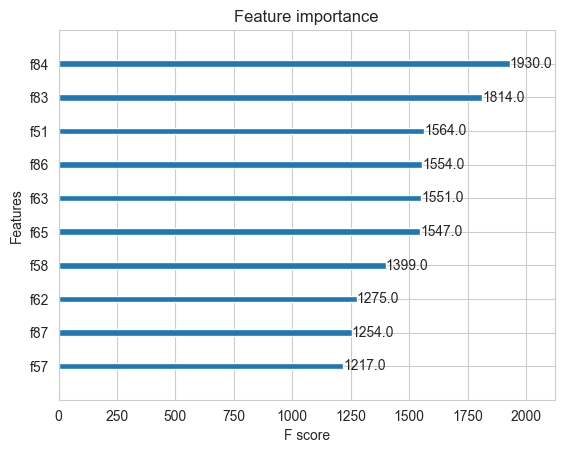

In [89]:
from xgboost import plot_importance
importance = best_model_adasyn.feature_importances_
plot_importance(best_model_adasyn, max_num_features=10, importance_type='weight')
plt.show()

100%|===================| 230608/230633 [68:59<00:00]        

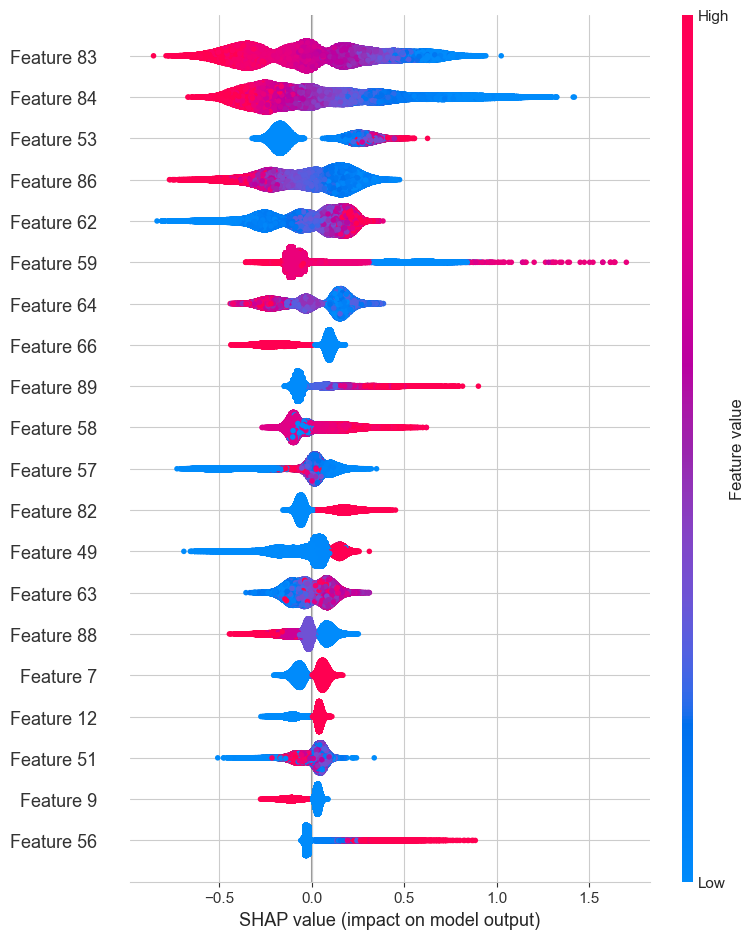

In [73]:
import shap

# Create SHAP explainer
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_train)

# Summary plot
shap.summary_plot(shap_values, X_train)

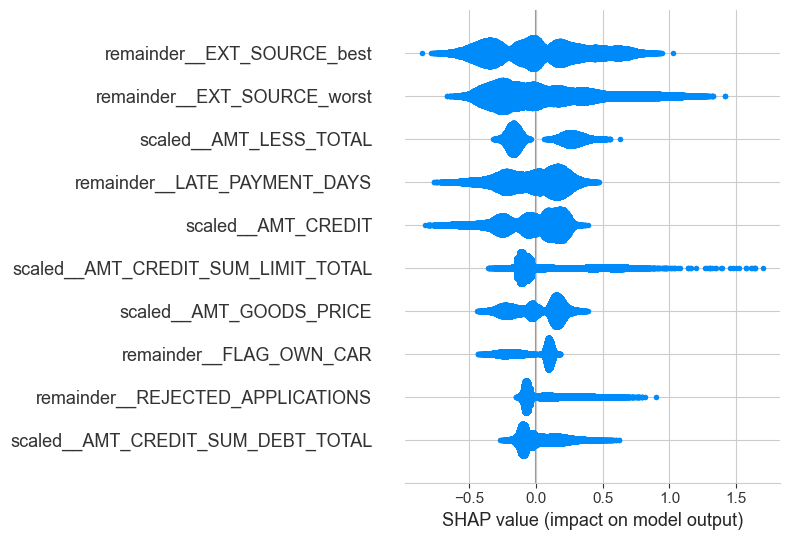

In [109]:
shap.summary_plot(shap_values, column_names, max_display=10)

In [105]:
shap_summary = pd.DataFrame({
    'Feature': column_names,
    'Mean SHAP Value': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='Mean SHAP Value', ascending=False)

shap_summary


,Feature,Mean SHAP Value
83,remainder__EXT_SOURCE_best,0.287173
84,remainder__EXT_SOURCE_worst,0.286190
53,scaled__AMT_LESS_TOTAL,0.211336
86,remainder__LATE_PAYMENT_DAYS,0.177589
62,scaled__AMT_CREDIT,0.168933
...,...,...
17,cat__NAME_FAMILY_STATUS_Unknown,0.000000
8,cat__NAME_EDUCATION_TYPE_Academic degree,0.000000
5,cat__NAME_INCOME_TYPE_Student,0.000000
2,cat__NAME_INCOME_TYPE_Maternity leave,0.000000
